In [13]:
import cv2
import onnxruntime as rt

import os
import time

from pathlib import Path
import yaml
import numpy as np

import matplotlib.pyplot as plt
from glob import glob

In [14]:
class AI:
    def __init__(self, config: dict):
        self.path = config['model']['path']

        self.sess = rt.InferenceSession(self.path, providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])
 
        self.output_name = self.sess.get_outputs()[0].name
        self.input_name = self.sess.get_inputs()[0].name

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        img_size = 64
        
        img = cv2.resize(img, (img_size, img_size))
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img)
        img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)
        
        img_crop = img_blurred[img_size//2:img_size, 0:img_size]
        img_crop = cv2.resize(img_crop, (img_size, img_size))
        
        img_normalized = img_crop.astype(np.float32) / 255.0
        img = np.expand_dims(img_normalized, axis=-1)

        return np.array([img]), img_normalized

    def postprocess(self, detections: np.ndarray) -> np.ndarray:
        ##TODO: prepare your outputs

        return detections

    def predict(self, img: np.ndarray) -> np.ndarray:
        inputs, _ = self.preprocess(img)

        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        outputs = self.postprocess(detections)


        return outputs

In [15]:
with open("../src/config.yml", "r") as stream:
        try:
            config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

ai = AI(config=config)

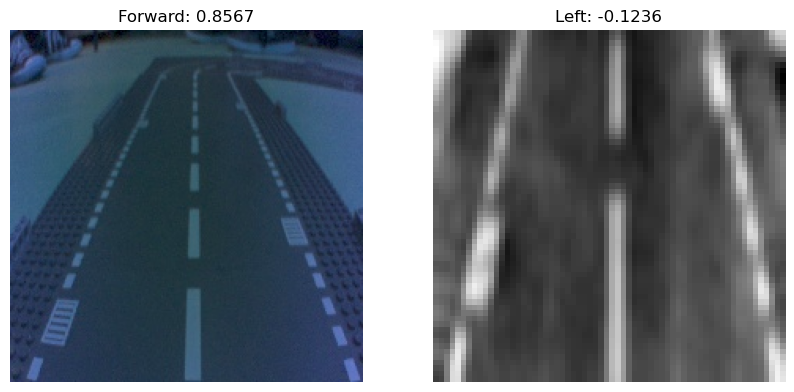

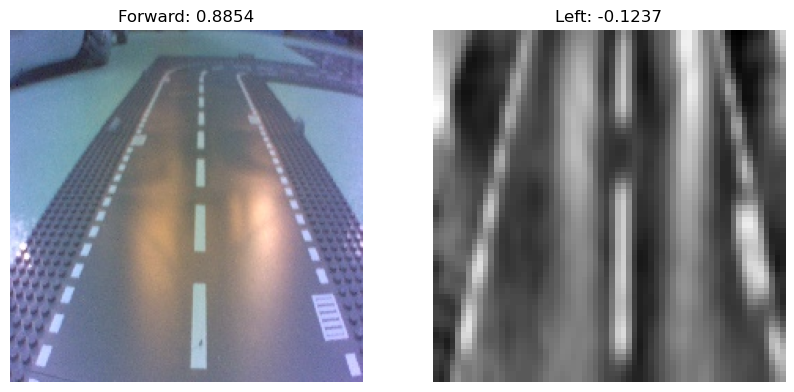

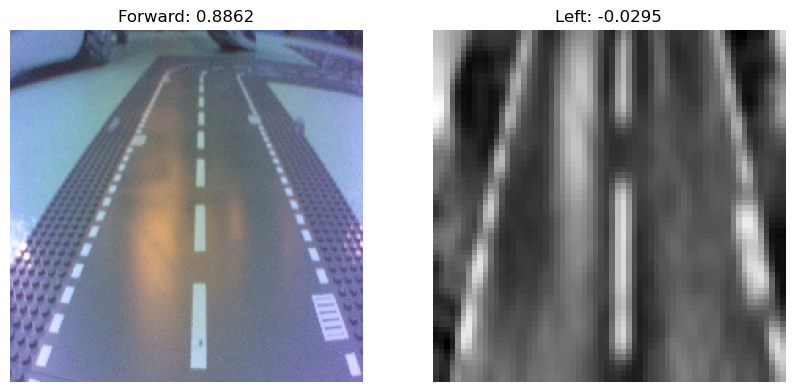

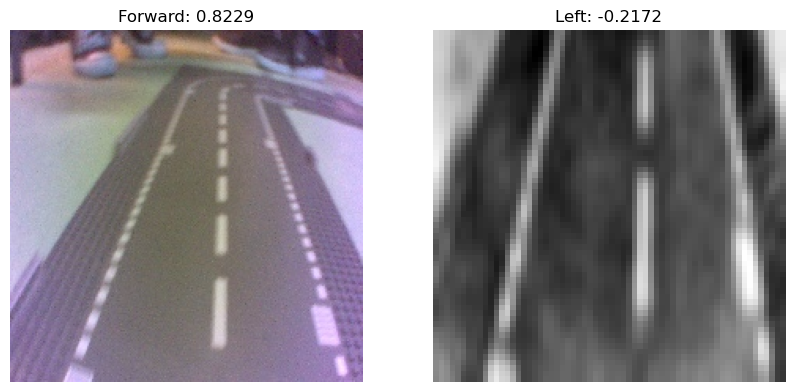

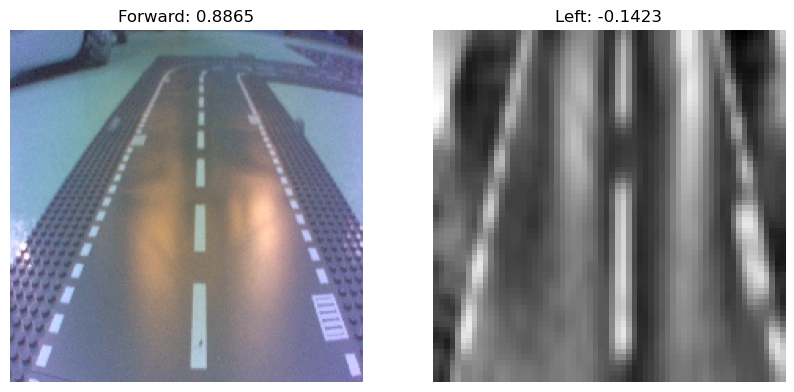

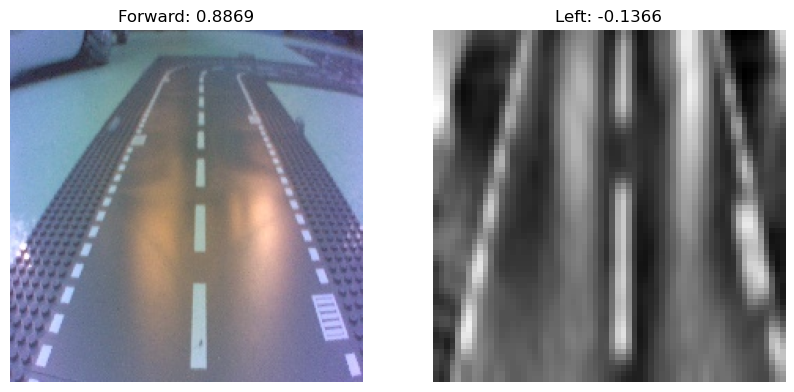

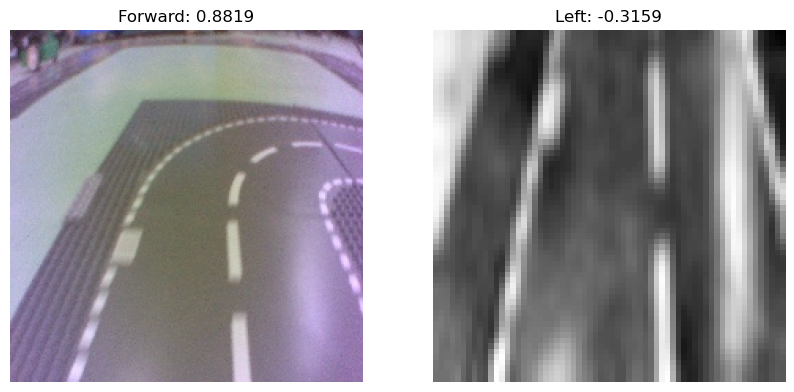

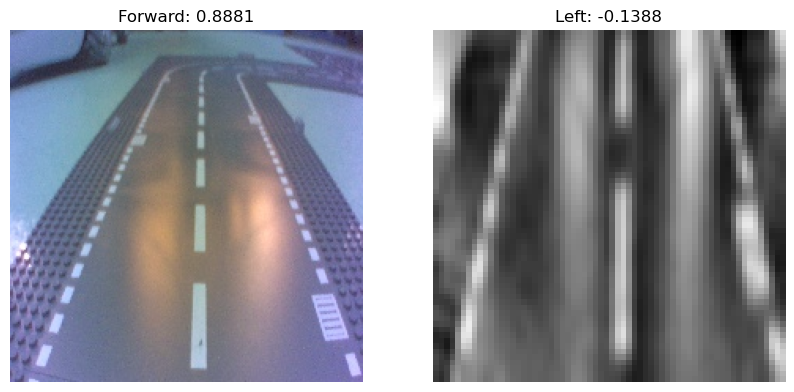

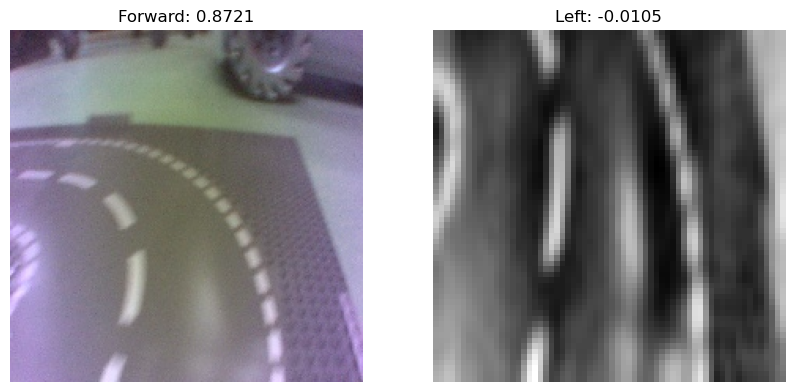

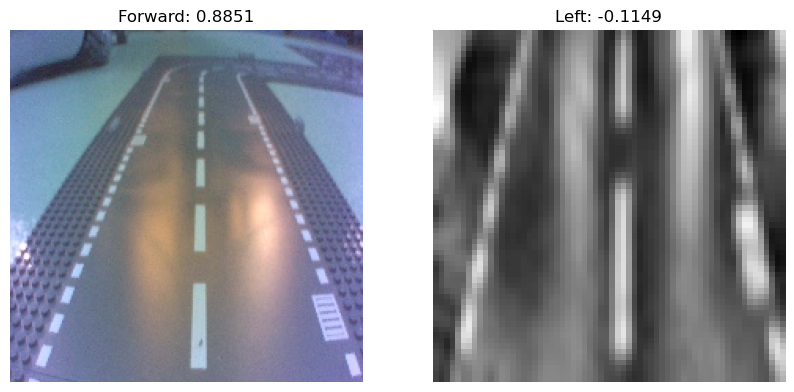

In [16]:
photo_path = "../test_runs/saved_images"

image_paths = glob(os.path.join(photo_path, "*.jpg"))

for img_path in image_paths:
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"Image not found: {img_path}")
        continue
    
    _, preprocessed_img = ai.preprocess(img_bgr)
    
    pred = ai.predict(img_bgr)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_bgr)
    ax[0].set_title(f"Forward: {pred[0][0]:.4f}")
    ax[0].axis("off")
    ax[1].imshow(preprocessed_img, cmap='gray')
    ax[1].set_title(f"Left: {pred[0][1]:.4f}")
    ax[1].axis("off")
    plt.show()
    
